<a href="https://colab.research.google.com/github/clarinct10/Big-Data-Airbnb-Project/blob/main/Airbnb_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project:  Analysis AirBnb Dataset Using Pyspark

In [ ]:
# Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import *
from pyspark.sql import functions as func
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation

spark = SparkSession.builder.getOrCreate()

ModuleNotFoundError: ignored

In [ ]:
# Spark UI
spark

In [ ]:
# Read the Dataset
df = spark.read.csv("hdfs://localhost:9000/clarin/AB_NYC_2019.csv",header=True)
df.show()

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca.

In [ ]:
# Check the number of datasets
df.count()

49079

In [ ]:
# Check the data overview and columns overview
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)

Columns overview


,Column Name,Data type
0,id,string
1,name,string
2,host_id,string
3,host_name,string
4,neighbourhood_group,string
5,neighbourhood,string
6,latitude,string
7,longitude,string
8,room_type,string
9,price,string


In [ ]:
#Check for the null values in each column
for col in df.columns:
    print(col, "\t", "with null values: ", df.filter(df[col].isNull()).count())

id 	 with null values:  0
name 	 with null values:  32
host_id 	 with null values:  185
host_name 	 with null values:  206
neighbourhood_group 	 with null values:  185
neighbourhood 	 with null values:  185
latitude 	 with null values:  185
longitude 	 with null values:  185
room_type 	 with null values:  185
price 	 with null values:  185
minimum_nights 	 with null values:  185
number_of_reviews 	 with null values:  205
last_review 	 with null values:  10234
reviews_per_month 	 with null values:  10215
calculated_host_listings_count 	 with null values:  187
availability_365 	 with null values:  342


In [ ]:
#Drop Rows with NULL Values
df.na.drop().show()

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca.

In [ ]:
# Check Statistical Information in Each Column
for col in df.columns:
     df.describe([col]).show()

+-------+--------------------+
|summary|                  id|
+-------+--------------------+
|  count|               49079|
|   mean|1.9017143236179568E7|
| stddev|1.0983108385610051E7|
|    min|  12 mins Manhattan"|
|    max| 獨一無二的紐約閣樓"|
+-------+--------------------+



+-------+-----------------------------+
|summary|                         name|
+-------+-----------------------------+
|  count|                        49047|
|   mean|              1.02037532075E8|
| stddev|          8.709090084371349E7|
|    min|          1 Bed Apt in Uto...|
|    max|ﾏﾝﾊｯﾀﾝ､駅から徒歩4分でどこ...|
+-------+-----------------------------+

+-------+--------------------+
|summary|             host_id|
+-------+--------------------+
|  count|               48894|
|   mean| 6.749591589946438E7|
| stddev| 7.855358174017511E7|
|    min| Heart of Greenwi...|
|    max|                呈刚|
+-------+--------------------+

+-------+--------------------+
|summary|           host_name|
+-------+--------------------+
|  count|               48873|
|   mean|                 NaN|
| stddev|                 NaN|
|    min| very clean studi...|
|    max|                현선|
+-------+--------------------+

+-------+-------------------+
|summary|neighbourhood_group|
+-------+-------------------+
| 

In [ ]:
# Number of Listings with Room Type
from pyspark.sql.functions import col, desc
df.groupBy("room_type") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(3)

+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt|25345|
|   Private room|22226|
|    Shared room| 1158|
+---------------+-----+
only showing top 3 rows



In [ ]:
def barplot(df, col, lim=10, yname=None):

    '''
    This function makes a bar plot for the Spark dataframe df
    for categorical column col only selecting top categories
    as specified by lim.
    '''

    # Grouping by the categories, counting on each categories
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)

    # Take first 'lim' number of rows and convert to pandas
    pd_df = classes.limit(lim).toPandas()

    # Making plot
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

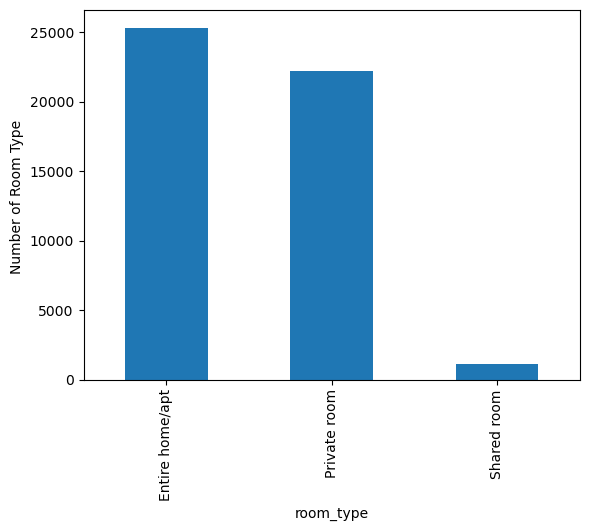

In [ ]:
barplot(df, 'room_type', lim=3, yname='Number of Room Type ')

In [ ]:
# Number of Listings with Neighbourhood Group
dataset = (
    spark.read.csv(
        path="hdfs://localhost:9000/clarin/AB_NYC_2019.csv",
        sep=",",
        header=True,
        quote='"',
    )
)
dataset.groupBy("neighbourhood_group") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(5)



+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|          Manhattan|21594|
|           Brooklyn|20055|
|             Queens| 5630|
|              Bronx| 1080|
|      Staten Island|  370|
+-------------------+-----+
only showing top 5 rows



In [ ]:
def pieplot(df, col, lim=10, yname=None):

    '''
    This function makes a pie chart for the Spark dataframe df
    for categorical column col only selecting top categories
    as specified by lim.
    '''

    # Grouping by the categories, counting on each categories
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)

    # Take first 'lim' number of rows and convert to pandas
    pd_df = classes.limit(lim).toPandas()

    # Making plot
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

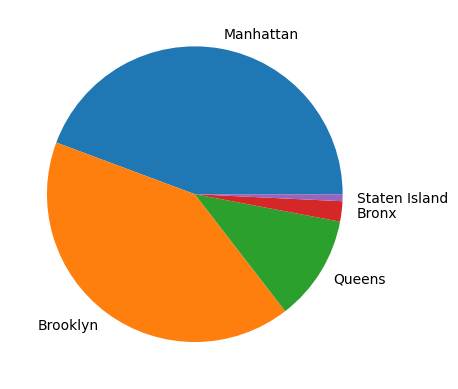

In [ ]:
li = ["Manhattan", "Brooklyn", "Queens","Staten Island", "Bronx"]
pieplot(df.filter(df.neighbourhood_group.isin(li)), 'neighbourhood_group')

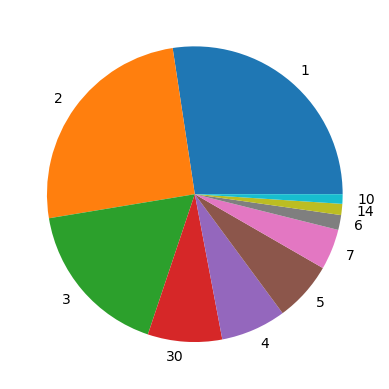

In [ ]:
# Minimum Number of Nights on Offer
pieplot(dataset, 'minimum_nights')

In [ ]:
# Check Neighbourhoods with the Highest Average Price in Each Neighbourhood Groups
from pyspark.sql.functions import avg
dataset.groupBy("neighbourhood","neighbourhood_group") \
    .agg(avg("price").alias("avg_price")) \
    .filter((dataset.neighbourhood  != "Woodrow")) \
    .sort(desc("avg_price")) \
    .show(4)

+--------------+-------------------+------------------+
| neighbourhood|neighbourhood_group|         avg_price|
+--------------+-------------------+------------------+
|Fort Wadsworth|      Staten Island|             800.0|
|      Sea Gate|           Brooklyn| 548.3333333333334|
|       Tribeca|          Manhattan|  490.638418079096|
|     Riverdale|              Bronx|442.09090909090907|
+--------------+-------------------+------------------+
only showing top 4 rows



In [ ]:
def barplot(dataset, col, lim=10, yname=None):

    classes = dataset.groupBy(col).agg(avg("price").alias("avg_price")).orderBy('avg_price', ascending=False).filter((dataset.neighbourhood  != "Woodrow"))
    pd_df = classes.limit(lim).toPandas()

    # Making plot
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

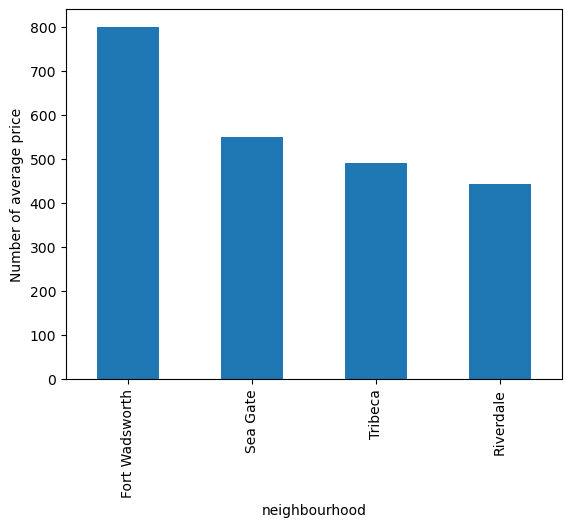

In [ ]:
barplot(dataset, 'neighbourhood', lim=4, yname='Number of average price')

In [ ]:
# Convert data type of Price Columns
dataset = dataset.withColumn("price",dataset.price.cast("Integer"))

In [ ]:
# Costliest listings in each neighbourhood groups
from pyspark.sql.functions import max
li = ["Nadia","Krista","William Hakan","D","Carmen","Evelyn","Seth"]
dataset.groupBy("name","neighbourhood_group") \
    .agg(max("price").alias("max_price")) \
    .filter(dataset.neighbourhood_group.isin(li)==False) \
    .sort(desc("max_price")) \
    .show(truncate=False)

+--------------------------------------------------+-------------------+---------+
|name                                              |neighbourhood_group|max_price|
+--------------------------------------------------+-------------------+---------+
|Luxury 1 bedroom apt. -stunning Manhattan views   |Brooklyn           |10000    |
|Furnished room in Astoria apartment               |Queens             |10000    |
|1-BR Lincoln Center                               |Manhattan          |10000    |
|Quiet, Clean, Lit @ LES & Chinatown               |Manhattan          |9999     |
|Spanish Harlem Apt                                |Manhattan          |9999     |
|2br - The Heart of NYC: Manhattans Lower East Side|Manhattan          |9999     |
|Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho |Manhattan          |8500     |
|Film Location                                     |Brooklyn           |8000     |
|East 72nd Townhouse by (Hidden by Airbnb)         |Manhattan          |7703     |
|Gem

In [ ]:
# Comparison of Room Type and Price in Different Neighbourhood Groups
li = ["Nadia","Krista","William Hakan","D","Carmen","Evelyn","Seth"]
dataset.groupBy("room_type","neighbourhood_group") \
    .agg(max("price").alias("max_price")) \
    .filter(dataset.neighbourhood_group.isin(li)==False) \
    .sort(desc("max_price")) \
    .show(15)

+---------------+-------------------+---------+
|      room_type|neighbourhood_group|max_price|
+---------------+-------------------+---------+
|Entire home/apt|           Brooklyn|    10000|
|   Private room|             Queens|    10000|
|Entire home/apt|          Manhattan|    10000|
|   Private room|          Manhattan|     9999|
|   Private room|           Brooklyn|     7500|
|Entire home/apt|      Staten Island|     5000|
|Entire home/apt|             Queens|     2600|
|   Private room|              Bronx|     2500|
|    Shared room|             Queens|     1800|
|    Shared room|          Manhattan|     1000|
|Entire home/apt|              Bronx|     1000|
|    Shared room|              Bronx|      800|
|    Shared room|           Brooklyn|      725|
|   Private room|      Staten Island|      300|
|    Shared room|      Staten Island|      150|
+---------------+-------------------+---------+
only showing top 15 rows



In [ ]:
# Create DataFrame
df = pd.DataFrame({"Private room":[9999, 7500, 10000, 300, 2500],
                   "Entire home/apt":[10000, 10000, 2600, 5000, 1000],
                   "Shared room":[1000, 725, 1800, 150, 800]},
                  index = ["Manhattan", "Brooklyn", "Queens","Staten Island", "Bronx"])
print(df)

               Private room  Entire home/apt  Shared room
Manhattan              9999            10000         1000
Brooklyn               7500            10000          725
Queens                10000             2600         1800
Staten Island           300             5000          150
Bronx                  2500             1000          800


Text(0, 0.5, 'Price')

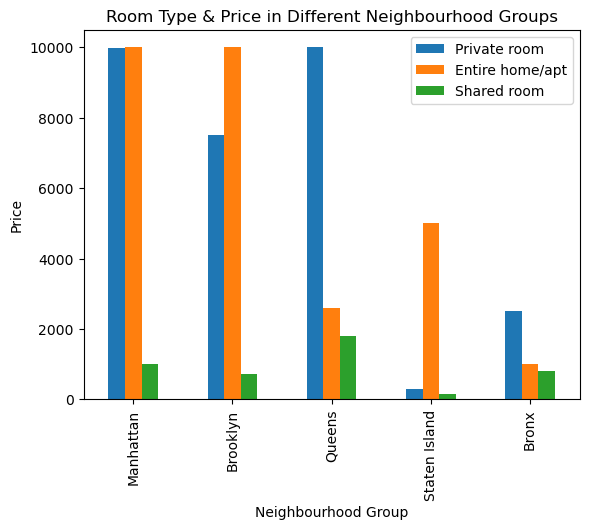

In [ ]:
df.plot(kind="bar")
plt.title("Room Type & Price in Different Neighbourhood Groups")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Price")

In [ ]:
# Top 10 most reviewed listings in New York City
dataset.groupBy("name","neighbourhood_group") \
    .agg(max("reviews_per_month").alias("max_review")) \
    .filter("neighbourhood_group != 'D'") \
    .sort(desc("max_review")) \
    .show(10)

+--------------------+-------------------+----------+
|                name|neighbourhood_group|max_review|
+--------------------+-------------------+----------+
|COZY Room for Fem...|           Brooklyn|      9.97|
|    Park Slope Villa|           Brooklyn|      9.93|
|A Little Sumptin'...|           Brooklyn|      9.85|
|Accessible Two Be...|          Manhattan|      9.85|
|   Peaches Paradise.|             Queens|      9.83|
|Private room near...|             Queens|      9.82|
|Best Value ❤️Memo...|          Manhattan|      9.78|
|Master Bedroom wi...|             Queens|      9.74|
|Cozy and private ...|             Queens|      9.73|
|Modern 2 Bedroom ...|           Brooklyn|      9.68|
+--------------------+-------------------+----------+
only showing top 10 rows



In [ ]:
# Monthly reviews with room types in each neighbourhood groups
dataset.groupBy("room_type","neighbourhood_group") \
    .agg(max("reviews_per_month").alias("max_review")) \
    .filter("neighbourhood_group != 'D'") \
    .sort(desc("max_review")) \
    .show(10)

+---------------+-------------------+----------+
|      room_type|neighbourhood_group|max_review|
+---------------+-------------------+----------+
|   Private room|           Brooklyn|      9.97|
|Entire home/apt|           Brooklyn|      9.93|
|   Private room|          Manhattan|      9.85|
|   Private room|             Queens|      9.83|
|Entire home/apt|          Manhattan|      9.78|
|Entire home/apt|             Queens|      9.63|
|   Private room|      Staten Island|      9.33|
|    Shared room|             Queens|      9.13|
|    Shared room|          Manhattan|      9.12|
|Entire home/apt|      Staten Island|      9.10|
+---------------+-------------------+----------+
only showing top 10 rows



In [ ]:
df = pd.DataFrame({
    'Private room': [9.33, 9.83,9.85, 9.97],
    'Entire home/apt': [9.10, 9.63, 9.78, 9.93],
    'Shared room': [0, 9.13, 9.12, 0 ],
    'Neighbourhood Groups': ['Staten Island', 'Queens', 'Manhattan', 'Brooklyn']
})
print(df)

   Private room  Entire home/apt  Shared room Neighbourhood Groups
0          9.33             9.10         0.00        Staten Island
1          9.83             9.63         9.13               Queens
2          9.85             9.78         9.12            Manhattan
3          9.97             9.93         0.00             Brooklyn


array([[<AxesSubplot:title={'center':'Private room'}>,
        <AxesSubplot:title={'center':'Entire home/apt'}>],
       [<AxesSubplot:title={'center':'Shared room'}>, <AxesSubplot:>]],
      dtype=object)

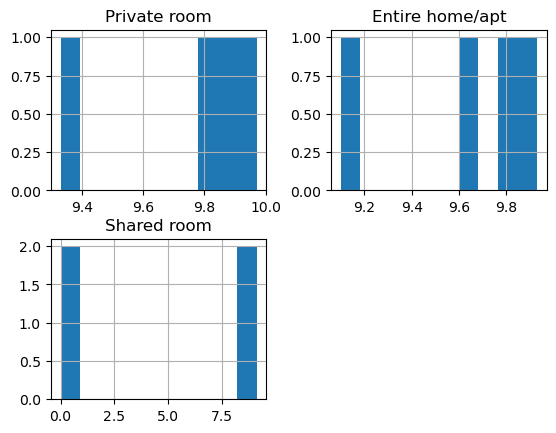

In [ ]:
df.hist()